In this project, I read the following articles: <br>
https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification
https://medium.com/%E9%9B%9E%E9%9B%9E%E8%88%87%E5%85%94%E5%85%94%E7%9A%84%E5%B7%A5%E7%A8%8B%E4%B8%96%E7%95%8C/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-ml-note-cnn%E6%BC%94%E5%8C%96%E5%8F%B2-alexnet-vgg-inception-resnet-keras-coding-668f74879306
<br>
<br>
In this computer vision project, we want to distinguish dogs from cats. I will implemented several CNN models such as LeNet5, AlexNet, VGG16, GoogLeNet (Inception1).

# Load data and libraries:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Input, concatenate, Flatten, Dense, Activation, BatchNormalization

In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [4]:
filenames = os.listdir("/kaggle/input/dogs-vs-cats/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,dog.1501.jpg,1
1,dog.2499.jpg,1
2,cat.5290.jpg,0
3,dog.1331.jpg,1
4,cat.280.jpg,0


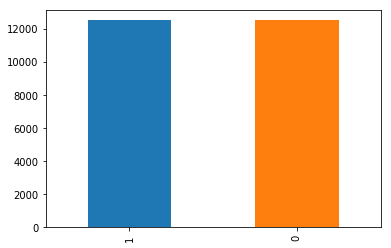

In [6]:
df['category'].value_counts().plot.bar()

# See sample image

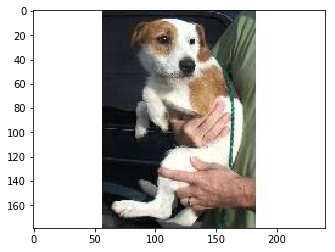

In [7]:
sample = random.choice(filenames)
image = load_img("/kaggle/input/dogs-vs-cats/train/train/"+sample)
plt.imshow(image)

# Callbacks

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Early Stop
<br>
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [10]:
earlystop = EarlyStopping(patience=10)

Learning Rate Reduction
<br>
We will reduce the learning rate when then accuracy not increase for 2 steps

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

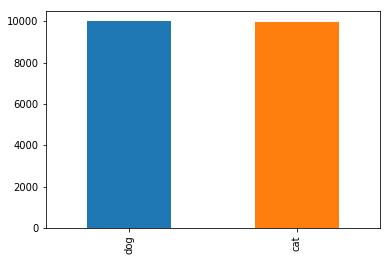

In [15]:
train_df['category'].value_counts().plot.bar()

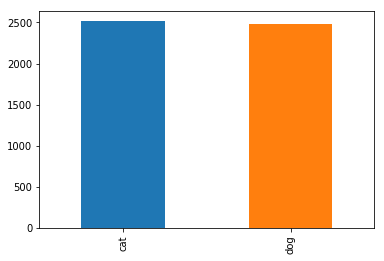

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=20

# Traning Generator

In [18]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.15,
      height_shift_range=0.15,
      shear_range=0.15,
      zoom_range=0.15,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


Validation Generator

In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/kaggle/input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


See how our generator work

In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/kaggle/input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


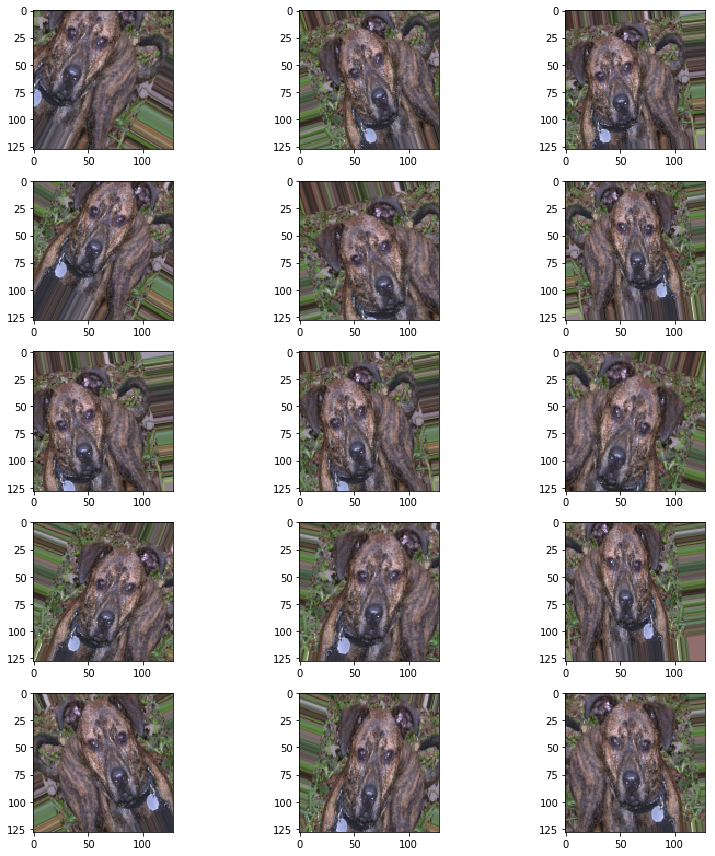

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Build Model

## LeNet5 CNN Model

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Input, concatenate, Flatten, Dense, Activation, BatchNormalization

lenet5 = Sequential()

lenet5.add(Conv2D(6, (5, 5), activation='tanh', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
lenet5.add(BatchNormalization())
lenet5.add(AveragePooling2D(pool_size=(2, 2)))
lenet5.add(Dropout(0.25))

lenet5.add(Conv2D(16, (5, 5), activation='tanh'))
lenet5.add(BatchNormalization())
lenet5.add(AveragePooling2D(pool_size=(2, 2)))
lenet5.add(Dropout(0.25))

lenet5.add(Flatten())
lenet5.add(Dense(120, activation='tanh'))
lenet5.add(BatchNormalization())
lenet5.add(Dropout(0.5))

lenet5.add(Dense(84, activation='tanh'))
lenet5.add(BatchNormalization())
lenet5.add(Dropout(0.5))

lenet5.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

lenet5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

lenet5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 124, 6)       456       
_________________________________________________________________
batch_normalization_5 (Batch (None, 124, 124, 6)       24        
_________________________________________________________________
average_pooling2d_1 (Average (None, 62, 62, 6)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 62, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 16)        2416      
_________________________________________________________________
batch_normalization_6 (Batch (None, 58, 58, 16)        64        
_________________________________________________________________
average_pooling2d_2 (Average (None, 29, 29, 16)        0         
__________

In [26]:
epochs=3
lenet5_history = lenet5.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1000/1000 [==============================] - 143s 143ms/step - loss: 0.8264 - acc: 0.5130 - val_loss: 0.6904 - val_acc: 0.5342
Epoch 2/3
1000/1000 [==============================] - 142s 142ms/step - loss: 0.6936 - acc: 0.5313 - val_loss: 0.6925 - val_acc: 0.5258
Epoch 3/3
1000/1000 [==============================] - 139s 139ms/step - loss: 0.6896 - acc: 0.5446 - val_loss: 0.6734 - val_acc: 0.5808


LeNet5 was doing okay. Not too bad but not that good as well.

## AlexNet

In [27]:
alexnet = Sequential()
    
alexnet.add(Conv2D(96,(11,11),strides=(4,4),input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),padding='valid',activation='relu'))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
alexnet.add(Dropout(0.5))
    
alexnet.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu'))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
alexnet.add(Dropout(0.5))
    
alexnet.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu'))
alexnet.add(BatchNormalization())
alexnet.add(Dropout(0.5))
alexnet.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu'))
alexnet.add(BatchNormalization())
alexnet.add(Dropout(0.5))
alexnet.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu'))
alexnet.add(BatchNormalization())
alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
alexnet.add(Dropout(0.5))
    
alexnet.add(Flatten())
alexnet.add(Dense(4096,activation='relu'))
alexnet.add(BatchNormalization())
alexnet.add(Dropout(0.5))
alexnet.add(Dense(4096,activation='relu'))
alexnet.add(BatchNormalization())
alexnet.add(Dropout(0.5))

alexnet.add(Dense(2, activation='softmax'))

alexnet.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

alexnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 96)        34944     
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 96)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 256)       1024      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 256)         0         
__________

In [28]:
epochs=8
alexnet_history = alexnet.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/8
1000/1000 [==============================] - 149s 149ms/step - loss: 1.5434 - acc: 0.5193 - val_loss: 0.9148 - val_acc: 0.5134
Epoch 2/8
1000/1000 [==============================] - 145s 145ms/step - loss: 1.1722 - acc: 0.5454 - val_loss: 0.6981 - val_acc: 0.5244
Epoch 3/8
1000/1000 [==============================] - 145s 145ms/step - loss: 1.1113 - acc: 0.5678 - val_loss: 0.9509 - val_acc: 0.5926
Epoch 4/8
1000/1000 [==============================] - 144s 144ms/step - loss: 1.0461 - acc: 0.5782 - val_loss: 1.3460 - val_acc: 0.4798
Epoch 5/8
1000/1000 [==============================] - 144s 144ms/step - loss: 0.9909 - acc: 0.6097 - val_loss: 2.1403 - val_acc: 0.5694

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/8
1000/1000 [==============================] - 143s 143ms/step - loss: 0.8983 - acc: 0.6395 - val_loss: 0.7484 - val_acc: 0.7004
Epoch 7/8
1000/1000 [==============================] - 145s 145ms/step - loss: 0.8785 - acc: 0.65

AlexNet worked a bit better than LeNet, but still not good enough.

## VGG16

In [34]:
VGG_16 = Sequential([
Conv2D(64, (3, 3), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), padding='same', activation='relu'),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
Conv2D(128, (3, 3), activation='relu', padding='same'),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(256, (3, 3), activation='relu', padding='same'),
Conv2D(256, (3, 3), activation='relu', padding='same'),
Conv2D(256, (3, 3), activation='relu', padding='same'),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same'),
Conv2D(512, (3, 3), activation='relu', padding='same'),
Conv2D(512, (3, 3), activation='relu', padding='same'),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same'),
Conv2D(512, (3, 3), activation='relu', padding='same'),
Conv2D(512, (3, 3), activation='relu', padding='same'),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Flatten(),
Dense(4096, activation='relu'),
Dense(4096, activation='relu'),
Dense(2, activation='softmax')
])

VGG_16.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

VGG_16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 32, 32, 256)       295168    
__________

In [35]:
epochs=3
VGG_16_history = VGG_16.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1000/1000 [==============================] - 164s 164ms/step - loss: 8.0194 - acc: 0.5021 - val_loss: 8.1203 - val_acc: 0.4962
Epoch 2/3
1000/1000 [==============================] - 157s 157ms/step - loss: 8.0550 - acc: 0.5003 - val_loss: 8.0719 - val_acc: 0.4992
Epoch 3/3
1000/1000 [==============================] - 158s 158ms/step - loss: 8.0542 - acc: 0.5003 - val_loss: 8.1687 - val_acc: 0.4932


VGG16 worked poorly.

## GoogLeNet (Inception1)

In [29]:
from keras.models import Model
#Define convolution with batchnromalization
def Conv2d_BN(x, nb_filter,kernel_size, padding='same',strides=(1,1),name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu',name=conv_name)(x)
    x = BatchNormalization(axis=3,name=bn_name)(x)
    return x

In [30]:
#Define Inception structure
def Inception(x,nb_filter_para):
    (branch1,branch2,branch3,branch4)= nb_filter_para
    branch1x1 = Conv2D(branch1[0],(1,1), padding='same',strides=(1,1),name=None)(x)

    branch3x3 = Conv2D(branch2[0],(1,1), padding='same',strides=(1,1),name=None)(x)
    branch3x3 = Conv2D(branch2[1],(3,3), padding='same',strides=(1,1),name=None)(branch3x3)

    branch5x5 = Conv2D(branch3[0],(1,1), padding='same',strides=(1,1),name=None)(x)
    branch5x5 = Conv2D(branch3[1],(1,1), padding='same',strides=(1,1),name=None)(branch5x5)

    branchpool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branchpool = Conv2D(branch4[0],(1,1),padding='same',strides=(1,1),name=None)(branchpool)

    x = concatenate([branch1x1,branch3x3,branch5x5,branchpool],axis=3)

    return x

In [31]:
#Build InceptionV1 model
def InceptionV1(width, height, depth, classes):
    
    inpt = Input(shape=(width,height,depth))

    x = Conv2d_BN(inpt,64,(7,7),strides=(2,2),padding='same')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = Conv2d_BN(x,192,(3,3),strides=(1,1),padding='same')
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    x = Inception(x,[(64,),(96,128),(16,32),(32,)]) #Inception 3a 28x28x256
    x = Inception(x,[(128,),(128,192),(32,96),(64,)]) #Inception 3b 28x28x480
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x) #14x14x480

    x = Inception(x,[(192,),(96,208),(16,48),(64,)]) #Inception 4a 14x14x512
    x = Inception(x,[(160,),(112,224),(24,64),(64,)]) #Inception 4a 14x14x512
    x = Inception(x,[(128,),(128,256),(24,64),(64,)]) #Inception 4a 14x14x512
    x = Inception(x,[(112,),(144,288),(32,64),(64,)]) #Inception 4a 14x14x528
    x = Inception(x,[(256,),(160,320),(32,128),(128,)]) #Inception 4a 14x14x832
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x) #7x7x832

    x = Inception(x,[(256,),(160,320),(32,128),(128,)]) #Inception 5a 7x7x832
    x = Inception(x,[(384,),(192,384),(48,128),(128,)]) #Inception 5b 7x7x1024

    #Using AveragePooling replace flatten
    x = AveragePooling2D(pool_size=(7,7),strides=(7,7),padding='same')(x)
    x =Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1000,activation='relu')(x)
    x = Dense(classes,activation='softmax')(x)
    
    model=Model(input=inpt,output=x)
    
    return model

In [32]:
InceptionV1_model = InceptionV1(128,128,3,2)
InceptionV1_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
InceptionV1_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 64, 64, 64)   256         conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 32, 32, 64)   0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv2d_12 

In [33]:
epochs=3
InceptionV1_history = InceptionV1_model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1000/1000 [==============================] - 155s 155ms/step - loss: 8.0483 - acc: 0.5004 - val_loss: 8.0945 - val_acc: 0.4978
Epoch 2/3
1000/1000 [==============================] - 149s 149ms/step - loss: 8.0639 - acc: 0.4997 - val_loss: 8.1429 - val_acc: 0.4948
Epoch 3/3
1000/1000 [==============================] - 151s 151ms/step - loss: 8.0389 - acc: 0.5013 - val_loss: 8.1332 - val_acc: 0.4954

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


Inception1 also worked poorly.

## Another model (model1):

https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

In [22]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [23]:
epochs=3 if FAST_RUN else 30
model1_history = model1.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30
1000/1000 [==============================] - 184s 184ms/step - loss: 0.7660 - acc: 0.6186 - val_loss: 0.5757 - val_acc: 0.7170
Epoch 2/30
1000/1000 [==============================] - 141s 141ms/step - loss: 0.5763 - acc: 0.7006 - val_loss: 0.5247 - val_acc: 0.7288
Epoch 3/30
1000/1000 [==============================] - 142s 142ms/step - loss: 0.5238 - acc: 0.7455 - val_loss: 1.0098 - val_acc: 0.6846
Epoch 4/30
1000/1000 [==============================] - 142s 142ms/step - loss: 0.4853 - acc: 0.7701 - val_loss: 0.5358 - val_acc: 0.7756
Epoch 5/30
1000/1000 [==============================] - 141s 141ms/step - loss: 0.4618 - acc: 0.7863 - val_loss: 0.4883 - val_acc: 0.7644
Epoch 6/30
1000/1000 [==============================] - 140s 140ms/step - loss: 0.4343 - acc: 0.7997 - val_loss: 0.4155 - val_acc: 0.8184
Epoch 7/30
1000/1000 [==============================] - 140s 140ms/step - loss: 0.4187 - acc: 0.8086 - val_loss: 0.4932 - val_acc: 0.8008
Epoch 8/30
1000/1000 [============

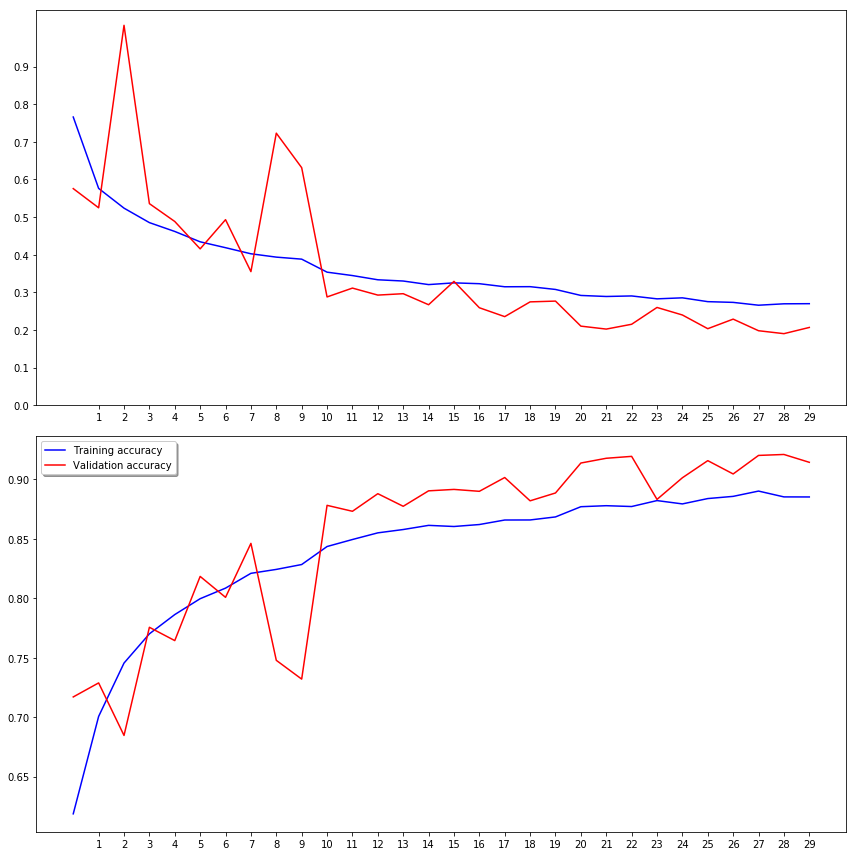

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model1_history.history['loss'], color='b', label="Training loss")
ax1.plot(model1_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model1_history.history['acc'], color='b', label="Training accuracy")
ax2.plot(model1_history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

It seems like we have the winner. Model1 performed quite well. The accuracy on validation set is about 92% after 25 epochs.

# Prepare Testing Data

In [36]:
test_filenames = os.listdir("/kaggle/input/dogs-vs-cats/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [38]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/kaggle/input/dogs-vs-cats/test1/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [39]:
predict1 = model1.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [41]:
test_df['category'] = np.argmax(predict1, axis=-1)

In [42]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [43]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

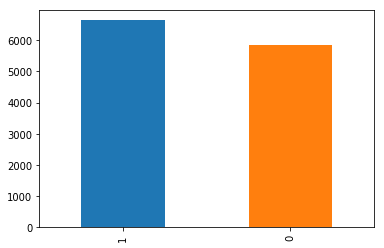

In [44]:
test_df['category'].value_counts().plot.bar()

## See predicted result with images

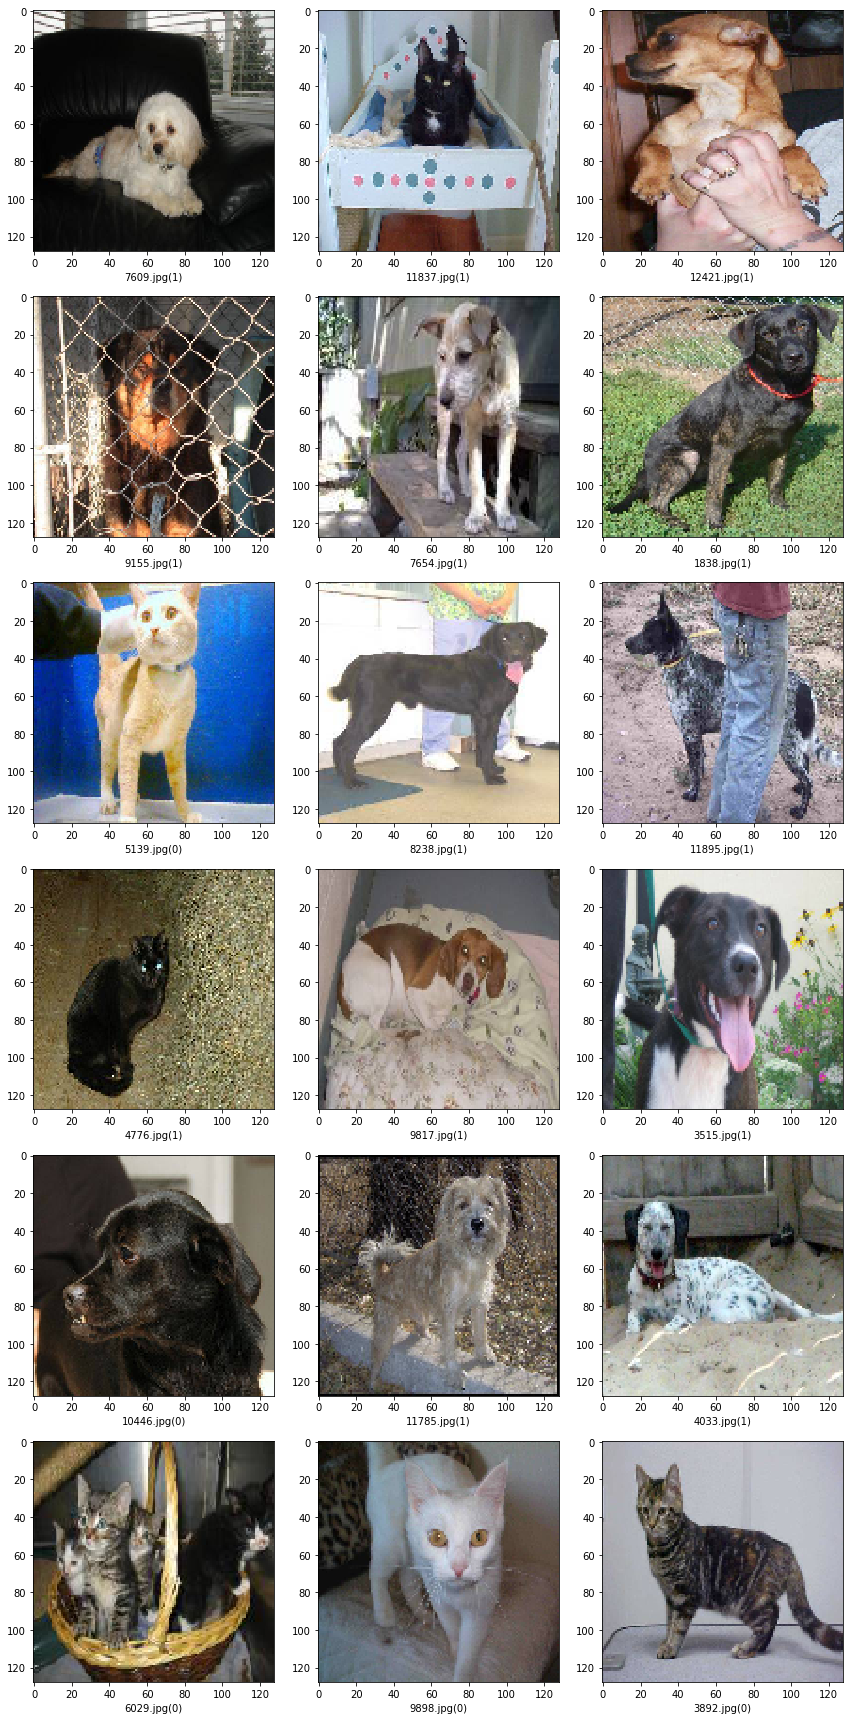

In [45]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/kaggle/input/dogs-vs-cats/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()